<a href="https://colab.research.google.com/github/bilnazir/stockmarketprediction/blob/main/fyp_transformer_google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas-ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=4dda199c59d0e331e48b888894d054eab69138e3a580b637c54e747e836779eb
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [3]:
import yfinance as yf

In [4]:
# Load historical stock data (date, closing price) into a pandas DataFrame
df = yf.download(tickers=['GOOG'], start='2012-01-01', end='2022-06-20')
data = df.dropna()


[*********************100%%**********************]  1 of 1 completed


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2633 entries, 2012-01-03 to 2022-06-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2633 non-null   float64
 1   High       2633 non-null   float64
 2   Low        2633 non-null   float64
 3   Close      2633 non-null   float64
 4   Adj Close  2633 non-null   float64
 5   Volume     2633 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 144.0 KB


In [6]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,16.262545,16.641375,16.248346,16.573130,16.554291,147611217
2012-01-04,16.563665,16.693678,16.453827,16.644611,16.625692,114989399
2012-01-05,16.491436,16.537264,16.344486,16.413727,16.395069,131808205
2012-01-06,16.417213,16.438385,16.184088,16.189817,16.171415,108119746
2012-01-09,16.102144,16.114599,15.472754,15.503389,15.485767,233776981
...,...,...,...,...,...,...
2022-06-13,107.445999,109.218498,106.588051,106.876503,106.755020,36756000
2022-06-14,106.889999,108.457497,106.351997,107.194000,107.072159,25480000
2022-06-15,108.899498,112.063004,108.118752,110.390503,110.265030,33192000


In [7]:
data.shape

(2633, 6)

In [8]:
# Adding indicators
import pandas_ta as ta
data['RSI'] = ta.rsi(data.Close, length=15)
data['EMAF'] = ta.ema(data.Close, length=20)
data['EMAM'] = ta.ema(data.Close, length=100)
data['EMAS'] = ta.ema(data.Close, length=150)

data['Target'] = data['Adj Close'] - data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i] > 0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['Volume', 'Close','Date'], axis=1, inplace=True)

<ipython-input-8-8a8148f44cbd>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['TargetClass'] = [1 if data.Target[i] > 0 else 0 for i in range(len(data))]


In [9]:
data_set = data.iloc[:, 0:11]
pd.set_option('display.max_columns', None)

data_set.head(20)

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
0,15.930538,16.173876,15.920825,15.992290,70.827616,15.289583,14.981082,15.106479,-0.049267,0,15.935568
1,15.984835,16.046354,15.852332,15.935568,69.002748,15.352832,15.000342,15.117700,0.061022,1,15.977612
2,15.916591,16.086454,15.902892,15.977612,69.624298,15.414067,15.020054,15.129331,-0.071984,0,15.980597
3,16.052582,16.098907,15.978110,15.980597,69.670565,15.469754,15.039434,15.140847,0.066755,1,15.971889
4,15.905134,15.996043,15.843863,15.971889,69.340468,15.519307,15.058259,15.152095,0.294891,1,16.419950
5,16.125059,16.442122,16.106628,16.419950,75.689867,15.606862,15.085593,15.169135,0.215441,1,16.635145
6,16.419704,16.758434,16.413479,16.635145,78.031058,15.706597,15.116652,15.188803,-0.087143,0,16.607283
7,16.694426,16.793304,16.540503,16.607283,77.002297,15.794176,15.146544,15.207841,0.114449,1,16.739883
8,16.625435,16.803019,16.614723,16.739883,78.450911,15.886058,15.178472,15.228385,0.056047,1,16.846115
9,16.790068,16.868025,16.729794,16.846115,79.556274,15.979318,15.211874,15.250066,-0.018129,0,16.806309


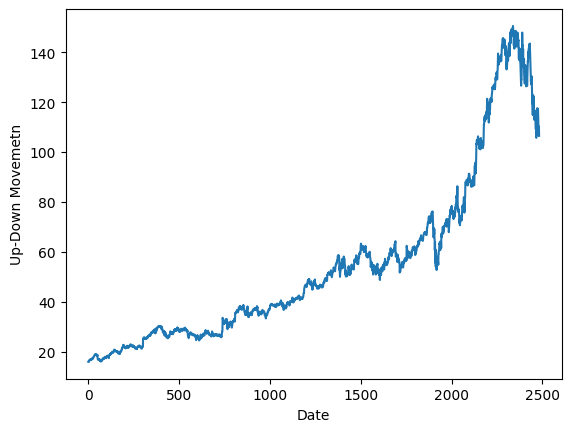

In [10]:
import matplotlib.pyplot as plt
data_set_AC=data_set['Adj Close']
plt.ylabel('Up-Down Movemetn')
plt.xlabel('Date')
plt.plot(data_set_AC)

In [11]:
# Normalize the data
sc = MinMaxScaler(feature_range=(0, 1))
data_set_scaled = sc.fit_transform(data)

In [12]:
# Prepare the data for training
X, y = [], []
backcandles = 20
for i in range(backcandles, data_set_scaled.shape[0]):
    X.append(data_set_scaled[i - backcandles:i, :-1])
    y.append(data_set_scaled[i, -1])

X, y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
# Build the Transformer model
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head self-attention mechanism
    attn_output = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    attn_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    # Feed-forward neural network
    ffn_output = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(attn_output)
    ffn_output = tf.keras.layers.Dropout(dropout)(ffn_output)
    ffn_output = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(ffn_output)
    return tf.keras.layers.LayerNormalization(epsilon=1e-6)(attn_output + ffn_output)

In [14]:
# Build the Transformer model
def build_transformer_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
):
    inputs = Input(shape=input_shape)

    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(dropout)(x)
    outputs = Dense(1)(x)

    return Model(inputs, outputs)

In [15]:
input_shape = X_train.shape[1:]
head_size = 128
num_heads = 4
ff_dim = 32
num_transformer_blocks = 8
mlp_units = [64, 32]

In [16]:
# Create and compile the Transformer model
model = build_transformer_model(
    input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    mlp_units=mlp_units,
    dropout=0.25,
)

model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])


In [17]:
# Training the model
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=128,
    validation_data=(X_test, y_test),
    verbose=1,
)

Epoch 1/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 61s 797ms/step - loss: 0.0467 - mean_absolute_error: 0.1606 - val_loss: 0.0068 - val_mean_absolute_error: 0.0572
Epoch 2/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0148 - mean_absolute_error: 0.0859 - val_loss: 0.0047 - val_mean_absolute_error: 0.0468
Epoch 3/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0127 - mean_absolute_error: 0.0809 - val_loss: 0.0028 - val_mean_absolute_error: 0.0398
Epoch 4/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0101 - mean_absolute_error: 0.0679 - val_loss: 0.0022 - val_mean_absolute_error: 0.0374
Epoch 5/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0096 - mean_absolute_error: 0.0689 - val_loss: 0.0035 - val_mean_absolute_error: 0.0486
Epoch 6/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0074 - mean_absolute_error: 0.0616 - val_loss: 0.0023 - val_mean_absolute_error: 0.0381
Epoch 7/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0077 - mean_absolute_error: 0.0599 -

In [18]:
# Convert training history to datafram for viewing and graphing.
hist = pd.DataFrame(history.history)
hist.head()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.032045,0.132070,0.006816,0.057221
1,0.015154,0.086456,0.004663,0.046804
2,0.011738,0.077635,0.002761,0.039819
3,0.009590,0.067038,0.002244,0.037415
4,0.009187,0.067730,0.003527,0.048635


<Axes: >

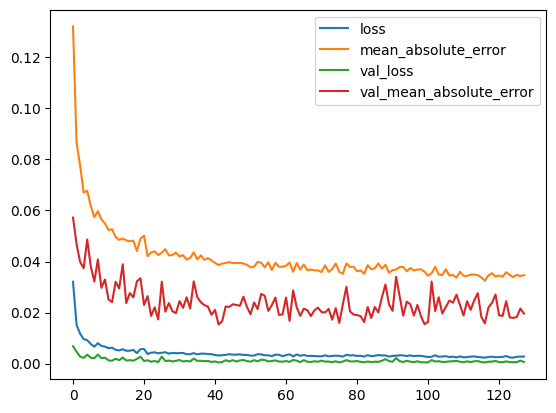

In [19]:
# Training errors with respect to ecochs.
# loss: values of the cost function for training data.
# val_loss: values of the cost function for cross-validation data.
hist.plot()

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 20, 10)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 20, 10)         │         22,026 │ input_layer[0][0],     │
│ (MultiHeadAttention)      │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 20, 10)         │              0 │ input_layer[0][0],     │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 20, 10)         │             20 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 20, 32)         │            352 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 20, 32)         │              0 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 20, 10)         │            330 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 20, 10)         │              0 │ layer_normalization[0… │
│                           │                        │                │ conv1d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 20, 10)         │             20 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 20, 10)         │         22,026 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 20, 10)         │              0 │ layer_normalization_1… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 20, 10)         │             20 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 20, 32)         │            352 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 20, 32)         │              0 │ conv1d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 20, 10)         │            330 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)          

 Total params: 554,405 (2.11 MB)

 Trainable params: 184,801 (721.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 369,604 (1.41 MB)

In [21]:
# Make predictions
y_pred = model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step


In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2) score: {r2:.4f}")

Mean Absolute Error (MAE): 0.0196
Mean Squared Error (MSE): 0.0006
Root Mean Squared Error (RMSE): 0.0253
R-squared (R2) score: 0.9894


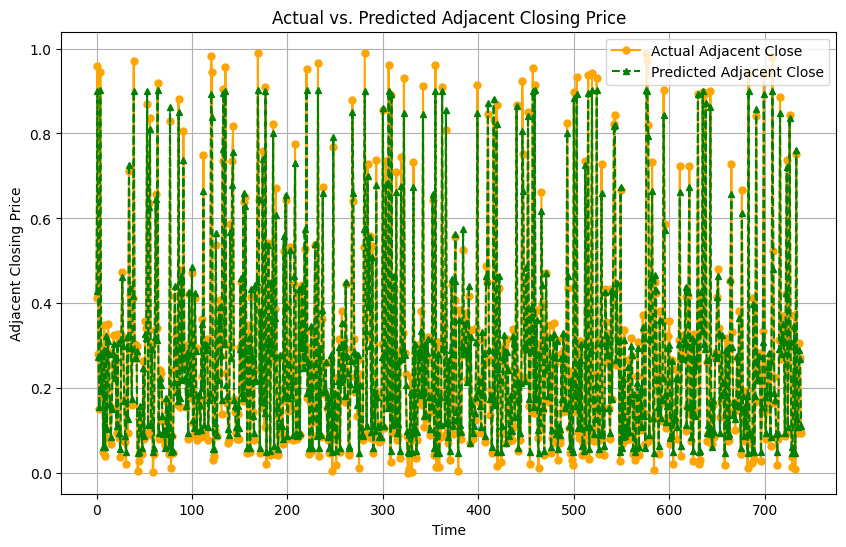

In [23]:
# Plot the actual and predicted adjacent closing prices
# Assuming y_test and y_pred are numpy arrays
y_test = y_test.squeeze()
y_pred = y_pred.squeeze()

plt.figure(figsize=(10, 6))  # Increase figure size for better visibility

# Plot actual values as blue circles
plt.plot(y_test, label='Actual Adjacent Close', color='orange', marker='o', linestyle='-', markersize=5)

# Plot predicted values as red triangles
plt.plot(y_pred, label='Predicted Adjacent Close', color='green', marker='^', linestyle='--', markersize=5)

plt.xlabel('Time')
plt.ylabel('Adjacent Closing Price')
plt.title('Actual vs. Predicted Adjacent Closing Price')
plt.legend()
plt.grid(True)  # Add grid lines for better readability
plt.show()

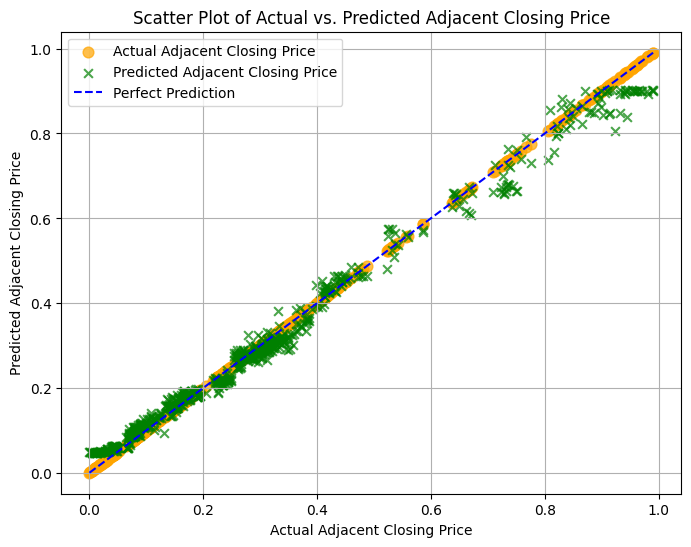

In [24]:
# Scatter plot of actual vs. predicted adjacent closing prices
plt.figure(figsize=(8, 6))  # Increase figure size for better visibility

# Plot actual values as orange circles with larger markers
plt.scatter(y_test, y_test, color='orange', label='Actual Adjacent Closing Price', alpha=0.7, s=60)

# Plot predicted values as black crosses with smaller markers
plt.scatter(y_test, y_pred, color='green', label='Predicted Adjacent Closing Price', alpha=0.7, s=40, marker='x')

# Plot the diagonal line for perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linestyle='--', label='Perfect Prediction')

plt.xlabel('Actual Adjacent Closing Price')
plt.ylabel('Predicted Adjacent Closing Price')
plt.title('Scatter Plot of Actual vs. Predicted Adjacent Closing Price')
plt.legend()
plt.grid(True)  # Add grid lines for better readability
plt.show()

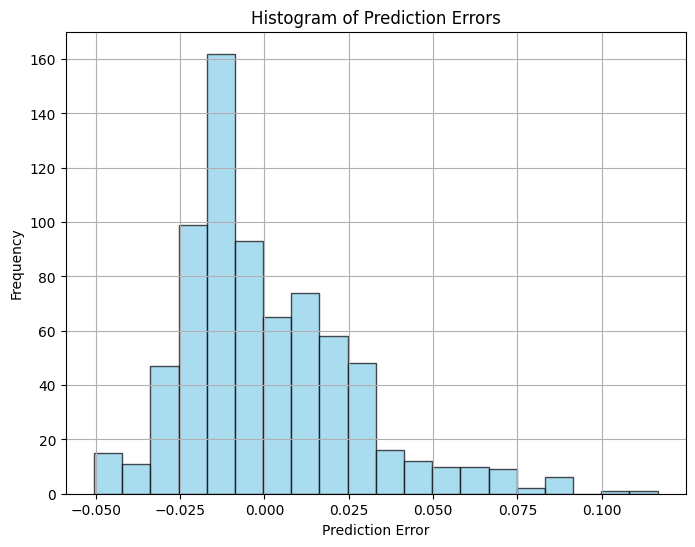

In [25]:
# Histogram of prediction errors
errors = y_test - y_pred

plt.figure(figsize=(8, 6))  # Increase figure size for better visibility

plt.hist(errors, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')

# Add grid lines for better readability
plt.grid(True)

plt.show()
